# Load data

This is a special analysis for the X chromosome. We look at

* DEL male (0, 1, 2) in PAR (1, 2) everywhere else
* DEL female (0, 1, 2)
* TDT (only from mom)

Combining male and female DEL is challenging since we know sex is associated with affected status and deletions will also be associated with affected status in non-PAR regions. TDT is ok because we ignore singledel_paternal in males.


In [1]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [125]:
import json

# load iHART deletions
with open('../final_calls/filtered_iHART_deletionsX.json', 'r') as f:
    ihart_deletions = json.load(f)
print(ihart_deletions[0])

# load iHART deletions
with open('../final_calls/filtered_SSC_deletionsX.json', 'r') as f:
    ssc_deletions = json.load(f)
print(ssc_deletions[0])

{'family': 'AU0080.AU008001.AU008002', 'chrom': 'X', 'start_pos': 140338490, 'end_pos': 140608905, 'length': 270416, 'opt_start_pos': 140337911, 'opt_end_pos': 140612588, 'opt_length': 274678, 'trans': ['AU008004'], 'notrans': [], 'is_mat': True, 'is_pat': False, 'mother': 'AU008001', 'father': 'AU008002'}
{'family': '12412.12412.mo.12412.fa', 'chrom': 'X', 'start_pos': 1108234, 'end_pos': 1118323, 'length': 10090, 'opt_start_pos': 1107713, 'opt_end_pos': 1118810, 'opt_length': 11098, 'trans': ['12412.s1'], 'notrans': [], 'is_mat': True, 'is_pat': False, 'mother': '12412.mo', 'father': '12412.fa'}


In [126]:
# ignore paternal deletions in non-PAR region
PAR1X_end = 2699520
PAR2X_start = 154931044

print(len(ihart_deletions))
ihart_deletions = [x for x in ihart_deletions if x['is_mat'] or x['end_pos'] <= PAR1X_end or x['start_pos'] >= PAR2X_start]
print(len(ihart_deletions))
print(len(ssc_deletions))
ssc_deletions = [x for x in ssc_deletions if x['is_mat'] or x['end_pos'] <= PAR1X_end or x['start_pos'] >= PAR2X_start]
print(len(ssc_deletions))

# restrict to par
#print(len(ihart_deletions))
#ihart_deletions = [x for x in ihart_deletions if x['end_pos'] <= PAR1X_end or x['start_pos'] >= PAR2X_start]
#print(len(ihart_deletions))
#print(len(ssc_deletions))
#ssc_deletions = [x for x in ssc_deletions if x['end_pos'] <= PAR1X_end or x['start_pos'] >= PAR2X_start]
#print(len(ssc_deletions))


# restrict to par1
#print(len(ihart_deletions))
#ihart_deletions = [x for x in ihart_deletions if x['end_pos'] <= PAR1X_end ]
#print(len(ihart_deletions))
#print(len(ssc_deletions))
#ssc_deletions = [x for x in ssc_deletions if x['end_pos'] <= PAR1X_end ]
#print(len(ssc_deletions))


128
93
80
70


In [127]:
# Pull cytogenetic coordinates
with open('../data/cytoBand.txt', 'r') as f:
    xticks, xticklabels = [], []
    chrom_length = 0
    for line in f:
        pieces = line.strip().split()
        if pieces[0] == 'chrX':
            xticks.append(int(pieces[1]))
            xticklabels.append(pieces[3])
            chrom_length = max(chrom_length, int(pieces[1]), int(pieces[2]))

In [128]:
print('iHART deletions', len(ihart_deletions), 'Maternal', len([x for x in ihart_deletions if x['is_mat']]), 
      'Paternal', len([x for x in ihart_deletions if x['is_pat']]))
print('iHART Maternal inheritance rate', sum([len(x['trans']) for x in ihart_deletions if x['is_mat']])/sum([len(x['trans']+x['notrans']) for x in ihart_deletions if x['is_mat']]))
print('iHART Paternal inheritance rate', sum([len(x['trans']) for x in ihart_deletions if x['is_pat']])/sum([len(x['trans']+x['notrans']) for x in ihart_deletions if x['is_pat']]))
print()

print('SSC deletions', len(ssc_deletions), 'Maternal', len([x for x in ssc_deletions if x['is_mat']]), 
      'Paternal', len([x for x in ssc_deletions if x['is_pat']]))
print('SSC Maternal inheritance rate', sum([len(x['trans']) for x in ssc_deletions if x['is_mat']])/sum([len(x['trans']+x['notrans']) for x in ssc_deletions if x['is_mat']]))
print('SSC Paternal inheritance rate', sum([len(x['trans']) for x in ssc_deletions if x['is_pat']])/sum([len(x['trans']+x['notrans']) for x in ssc_deletions if x['is_pat']]))

      
      

iHART deletions 93 Maternal 59 Paternal 34
iHART Maternal inheritance rate 0.6214285714285714
iHART Paternal inheritance rate 0.6790123456790124

SSC deletions 70 Maternal 47 Paternal 23
SSC Maternal inheritance rate 0.7204301075268817
SSC Paternal inheritance rate 0.6956521739130435


# Analyze relationship between deletions and disease
We're going to look at both deletion status (DEL) as well as deletion transmission disequilibrium (TDT) and parental differences (PAR) as a baseline.

In [129]:
import numpy as np

deletions = ihart_deletions+ssc_deletions

positions = sorted(set(sum([[(x['chrom'], x['start_pos']), (x['chrom'], x['end_pos'])] for x in deletions], [])))
individuals = sorted(set(sum([x['trans']+x['notrans'] for x in deletions], [])))
pos_to_index = dict([(x, i) for i, x in enumerate(positions)])
ind_to_index = dict([(x, i) for i, x in enumerate(individuals)])
dm = np.zeros((len(ind_to_index), len(pos_to_index)), dtype=int)
for d in deletions:
    start_index, end_index = pos_to_index[(d['chrom'], d['start_pos'])], pos_to_index[(d['chrom'], d['end_pos'])]
    for ind in d['trans']:
        dm[ind_to_index[ind], start_index:(end_index+1)] = 1

In [130]:
print(len([x for x in individuals if not x.startswith('A')]))

119


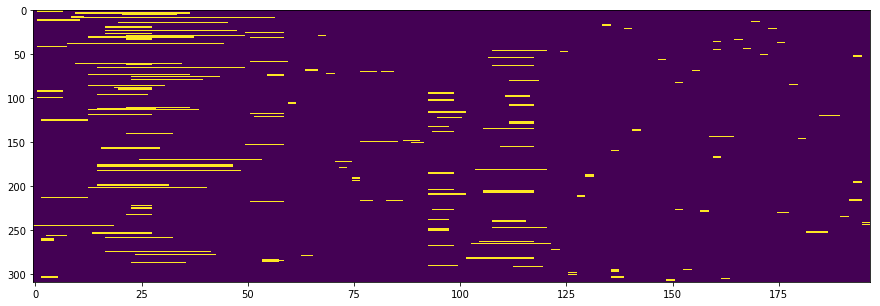

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.imshow(dm, aspect='auto')
plt.show()

In [132]:
in_par = np.zeros((len(positions),), dtype=int)
in_par[[i for i, x in enumerate(positions) if x[1] <= PAR1X_end]] = 1
in_par[[i for i, x in enumerate(positions) if x[1] >= PAR2X_start]] = 1


In [133]:
# Create contingency tables for each comparison
# position, deletion, affected, sex
tdt_conting_t = np.zeros((len(positions), 2, 2, 2, 2, 2), dtype=int)  

for d in ihart_deletions:
    start_index, end_index = pos_to_index[(d['chrom'], d['start_pos'])], pos_to_index[(d['chrom'], d['end_pos'])]
    if d['is_mat']:
        # maternal deletion
        for x in d['trans']:
            sex = int(child_id_to_sex[x] != '1')
            affected = int(child_id_to_affected[x] != '2')
            tdt_conting_t[start_index:(end_index+1), 0, affected, sex, 0, 0] += 1
        
        for x in d['notrans']:
            sex = int(child_id_to_sex[x] != '1')
            affected = int(child_id_to_affected[x] != '2')
            tdt_conting_t[start_index:(end_index+1), 1, affected, sex, 0, 0] += 1
            
    if d['is_pat']:
        # dad
        for x in d['trans']:
            sex = int(child_id_to_sex[x] != '1')
            affected = int(child_id_to_affected[x] != '2')
            tdt_conting_t[start_index:(end_index+1), 0, affected, sex, 1, 0] += 1
        
        for x in d['notrans']:
            sex = int(child_id_to_sex[x] != '1')
            affected = int(child_id_to_affected[x] != '2')
            tdt_conting_t[start_index:(end_index+1), 1, affected, sex, 1, 0] += 1

for d in ssc_deletions:
    start_index, end_index = pos_to_index[(d['chrom'], d['start_pos'])], pos_to_index[(d['chrom'], d['end_pos'])]
    if d['is_mat']:
        # maternal deletion
        for x in d['trans']:
            sex = int(child_id_to_sex[x] != '1')
            affected = int(child_id_to_affected[x] != '2')
            tdt_conting_t[start_index:(end_index+1), 0, affected, sex, 0, 1] += 1
        
        for x in d['notrans']:
            sex = int(child_id_to_sex[x] != '1')
            affected = int(child_id_to_affected[x] != '2')
            tdt_conting_t[start_index:(end_index+1), 1, affected, sex, 0, 1] += 1
            
    if d['is_pat']:
        # dad
        for x in d['trans']:
            sex = int(child_id_to_sex[x] != '1')
            affected = int(child_id_to_affected[x] != '2')
            tdt_conting_t[start_index:(end_index+1), 0, affected, sex, 1, 1] += 1
        
        for x in d['notrans']:
            sex = int(child_id_to_sex[x] != '1')
            affected = int(child_id_to_affected[x] != '2')
            tdt_conting_t[start_index:(end_index+1), 1, affected, sex, 1, 1] += 1

In [134]:
from scipy.stats import chi2_contingency, fisher_exact

num_tests = 0

max_index = len(positions)
tdt_pvalues = np.ones((max_index,))
tdt_male_pvalues = np.ones((max_index,))
tdt_female_pvalues = np.ones((max_index,))
tdt_mat_pvalues = np.ones((max_index,))
tdt_pat_pvalues = np.ones((max_index,))
ihart_pvalues = np.ones((max_index,))
ssc_pvalues = np.ones((max_index,))

for dc_t, p in [(np.sum(tdt_conting_t, axis=(3, 4, 5)), tdt_pvalues),
              (np.sum(tdt_conting_t, axis=(4, 5))[:, :, 0], tdt_female_pvalues),
              (np.sum(tdt_conting_t, axis=(4, 5))[:, :, 1], tdt_male_pvalues),
              (np.sum(tdt_conting_t, axis=(3, 5))[:, :, 0], tdt_mat_pvalues),
              (np.sum(tdt_conting_t, axis=(3, 5))[:, :, 1], tdt_pat_pvalues),
              (np.sum(tdt_conting_t, axis=(3, 4))[:, :, 0], ihart_pvalues),
              (np.sum(tdt_conting_t, axis=(3, 4))[:, :, 1], ssc_pvalues),
             ]:
    prev_i = 0
    for i in range(max_index):
        dc = dc_t[i, :, :]

        # get rid of 0 rows/columns
        dc = dc[np.ix_(np.sum(dc, axis=1)>0, np.sum(dc, axis=0)>0)]        

        # calculate pvalue
        if dc.shape[0] > 1 and dc.shape[1] > 1:
            pvalue = chi2_contingency(dc, correction=True)[1]
            num_tests += 1
        #elif dc_t[i, :, :].shape == (2, 2):
        #    pvalue = fisher_exact(dc_t[i, :, :])[1]
        else:
            pvalue = 1
        p[prev_i:i] = pvalue
        prev_i = i
print(num_tests)

641


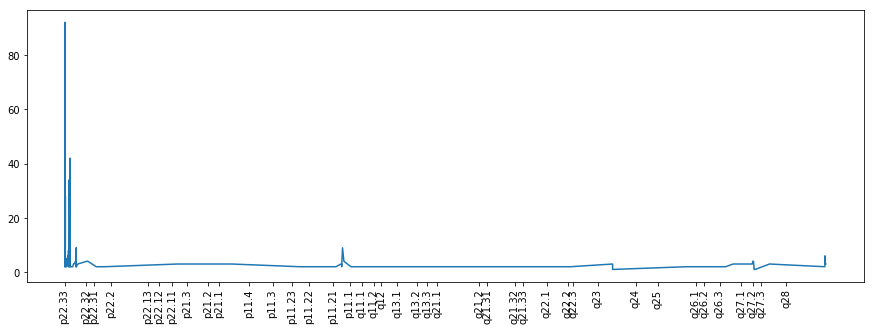

In [135]:
plt.figure(figsize=(15, 5))

plt.plot([x[1] for x in positions], np.sum(tdt_conting_t, axis=(1, 2, 3, 4, 5)))
plt.xticks(xticks, xticklabels, rotation='vertical')

plt.show()

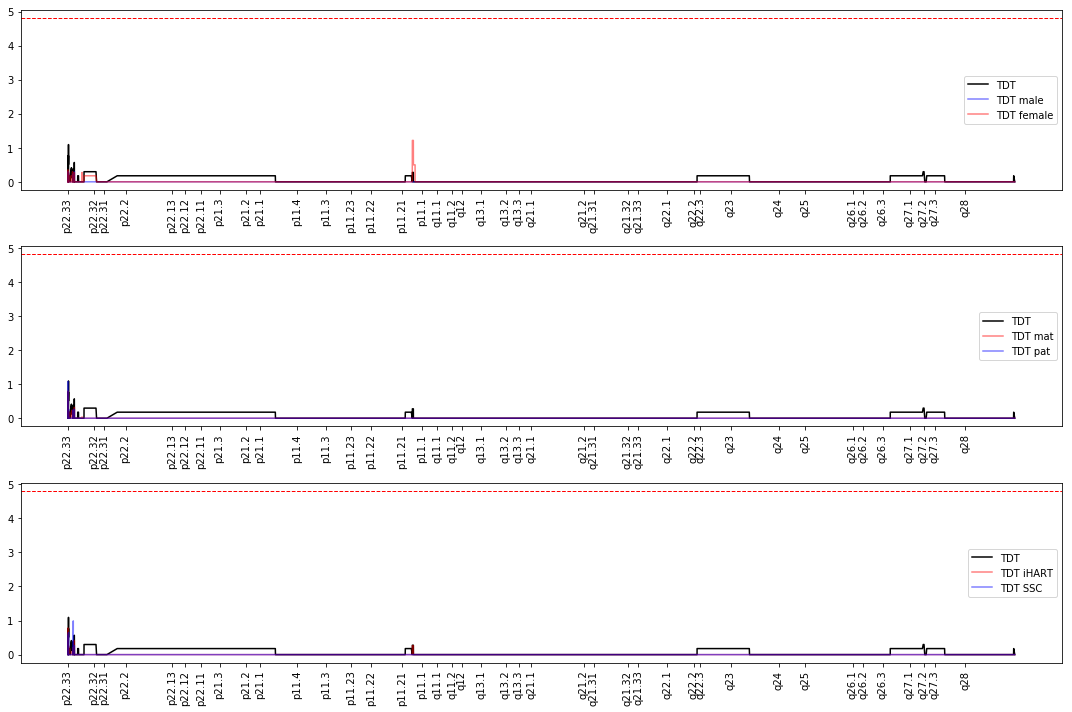

In [136]:
# plot pvalues
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot([x[1] for x in positions], -np.log10(tdt_pvalues), label='TDT', color='black')
plt.plot([x[1] for x in positions], -np.log10(tdt_male_pvalues), alpha=0.5, label='TDT male', color='blue')
plt.plot([x[1] for x in positions], -np.log10(tdt_female_pvalues), alpha=0.5, label='TDT female', color='red')

plt.axhline(y=-np.log10(0.01/num_tests), linewidth=1, linestyle='--', color='r')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[0])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[1])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[0])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot([x[1] for x in positions], -np.log10(tdt_pvalues), label='TDT', color='black')
plt.plot([x[1] for x in positions], -np.log10(tdt_mat_pvalues), alpha=0.5, label='TDT mat', color='red')
plt.plot([x[1] for x in positions], -np.log10(tdt_pat_pvalues), alpha=0.5, label='TDT pat', color='blue')

plt.axhline(y=-np.log10(0.01/num_tests), linewidth=1, linestyle='--', color='r')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[0])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[1])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[0])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot([x[1] for x in positions], -np.log10(tdt_pvalues), label='TDT', color='black')
plt.plot([x[1] for x in positions], -np.log10(ihart_pvalues), alpha=0.5, label='TDT iHART', color='red')
plt.plot([x[1] for x in positions], -np.log10(ssc_pvalues), alpha=0.5, label='TDT SSC', color='blue')

plt.axhline(y=-np.log10(0.01/num_tests), linewidth=1, linestyle='--', color='r')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[0])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR1X[1])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[0])[0])], linewidth=1, linestyle='--', color='black')
#plt.axvline(x=snp_positions[np.min(np.where(snp_positions>PAR2X[1])[0])], linewidth=1, linestyle='--', color='black')
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.legend()

plt.tight_layout()
plt.show()

3
4
5
6


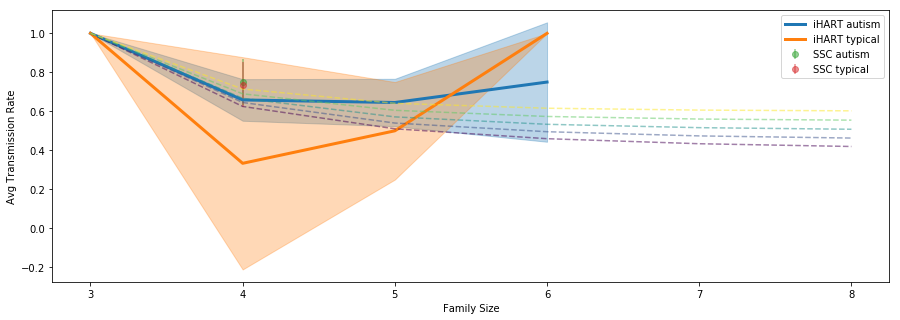

In [122]:
from scipy.stats import binom
import cycler
import matplotlib
import math

plt.figure(figsize=(15, 5))
prop_cycle = plt.rcParams['axes.prop_cycle']
matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
colors = prop_cycle.by_key()['color']

ps = [0.4, 0.45, 0.5, 0.55, 0.6]


aff_trs, aff_ns, typ_trs, typ_ns = [], [], [], []
for familysize in [3, 4, 5, 6]:
    print(familysize)
    n = sum([len([y for y in x['trans']+x['notrans'] if child_id_to_affected[y] == '2']) for x in ihart_deletions if len(x['trans']+x['notrans'])==familysize-2])
    tr = sum([len([y for y in x['trans'] if child_id_to_affected[y] == '2']) for x in ihart_deletions if len(x['trans']+x['notrans'])==familysize-2])/n
    aff_trs.append(tr)
    aff_ns.append(n)
    
    n = sum([len([y for y in x['trans']+x['notrans'] if child_id_to_affected[y] == '1']) for x in ihart_deletions if len(x['trans']+x['notrans'])==familysize-2])
    tr = sum([len([y for y in x['trans'] if child_id_to_affected[y] == '1']) for x in ihart_deletions if len(x['trans']+x['notrans'])==familysize-2])/n
    typ_trs.append(tr)
    typ_ns.append(n)

matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.viridis(np.linspace(0, 1, len(ps))))

plt.plot(range(1, 5), aff_trs, linewidth=3, label='iHART autism', color=colors[0])
plt.fill_between(range(1, 5), [p-2*math.sqrt(p*(1-p)/n) for (p, n) in zip(aff_trs, aff_ns)], [p+2*math.sqrt(p*(1-p)/n) for (p, n) in zip(aff_trs, aff_ns)], alpha=0.3, color=colors[0])
plt.plot(range(1, 5), typ_trs, linewidth=3, label='iHART typical', color=colors[1])
plt.fill_between(range(1, 5), [p-2*math.sqrt(p*(1-p)/n) for (p, n) in zip(typ_trs, typ_ns)], [p+2*math.sqrt(p*(1-p)/n) for (p, n) in zip(typ_trs, typ_ns)], alpha=0.3, color=colors[1])

ssc_aff_n = sum([len([y for y in x['trans']+x['notrans'] if child_id_to_affected[y] == '2']) for x in ssc_deletions])
ssc_aff_tr = sum([len([y for y in x['trans'] if child_id_to_affected[y] == '2']) for x in ssc_deletions])/ssc_aff_n
ssc_typ_n = sum([len([y for y in x['trans']+x['notrans'] if child_id_to_affected[y] == '1']) for x in ssc_deletions])
ssc_typ_tr = sum([len([y for y in x['trans'] if child_id_to_affected[y] == '1']) for x in ssc_deletions])/ssc_typ_n

plt.errorbar([2], [ssc_aff_tr], yerr=2*math.sqrt(ssc_aff_tr*(1-ssc_aff_tr)/ssc_aff_n), fmt='o', alpha=0.5, label='SSC autism', color=colors[2])
plt.errorbar([2], [ssc_typ_tr], yerr=2*math.sqrt(ssc_typ_tr*(1-ssc_typ_tr)/ssc_typ_n), fmt='o', alpha=0.5, label='SSC typical', color=colors[3])


xs = range(1, 7)
for p in ps:
    ts, ns = np.zeros((len(xs,))), np.zeros((len(xs,)))
    for j, x in enumerate(xs):
        t = sum([i*binom.pmf(i, x, p) for i in range(1, x+1)])
        n = sum([(x-i)*binom.pmf(i, x, p) for i in range(1, x+1)])
        ts[j] = t
        ns[j] = n
    ys = ts/(ts+ns)
    plt.plot(xs, ys, linestyle='--', alpha=0.5)
    
plt.legend()
plt.xticks(range(1, 7), range(3, 9))
plt.ylabel('Avg Transmission Rate')
plt.xlabel('Family Size')

plt.show()
matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


In [123]:
from scipy.stats import chi2_contingency

print('All')
d = deletions
print('Maternal vs Paternal')
c = [[sum([len(x['trans']) for x in d if x['is_mat']]),
     sum([len(x['notrans']) for x in d if x['is_mat']])],
    [sum([len(x['trans']) for x in d if x['is_pat']]),
    sum([len(x['notrans']) for x in d if x['is_pat']])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Autistic vs Typical')
c = [[sum([len([y for y in x['trans'] if child_id_to_affected[y] == '2']) for x in d]),
     sum([len([y for y in x['notrans'] if child_id_to_affected[y] == '2']) for x in d])],
    [sum([len([y for y in x['trans'] if child_id_to_affected[y] != '2']) for x in d]),
    sum([len([y for y in x['notrans'] if child_id_to_affected[y] != '2']) for x in d])]]
print(np.sum(c, axis=1))
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Female vs Male')
c = [[sum([len([y for y in x['trans'] if child_id_to_sex[y] == '2']) for x in d]),
     sum([len([y for y in x['notrans'] if child_id_to_sex[y] == '2']) for x in d])],
    [sum([len([y for y in x['trans'] if child_id_to_sex[y] == '1']) for x in d]),
    sum([len([y for y in x['notrans'] if child_id_to_sex[y] == '1']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Females: Autistic vs Typical')
c = [[sum([len([y for y in x['trans'] if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '2']) for x in d]),
     sum([len([y for y in x['notrans'] if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '2']) for x in d])],
    [sum([len([y for y in x['trans'] if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '2']) for x in d]),
    sum([len([y for y in x['notrans'] if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '2']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Males: Autistic vs Typical')
c = [[sum([len([y for y in x['trans'] if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d]),
     sum([len([y for y in x['notrans'] if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d])],
    [sum([len([y for y in x['trans'] if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d]),
    sum([len([y for y in x['notrans'] if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('iHART')
d = ihart_deletions
print('Maternal vs Paternal')
c = [[sum([len(x['trans']) for x in d if x['is_mat']]),
     sum([len(x['notrans']) for x in d if x['is_mat']])],
    [sum([len(x['trans']) for x in d if x['is_pat']]),
    sum([len(x['notrans']) for x in d if x['is_pat']])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Autistic vs Typical')
c = [[sum([len([y for y in x['trans'] if child_id_to_affected[y] == '2']) for x in d]),
     sum([len([y for y in x['notrans'] if child_id_to_affected[y] == '2']) for x in d])],
    [sum([len([y for y in x['trans'] if child_id_to_affected[y] != '2']) for x in d]),
    sum([len([y for y in x['notrans'] if child_id_to_affected[y] != '2']) for x in d])]]
print(np.sum(c, axis=1))
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Female vs Male')
c = [[sum([len([y for y in x['trans'] if child_id_to_sex[y] == '2']) for x in d]),
     sum([len([y for y in x['notrans'] if child_id_to_sex[y] == '2']) for x in d])],
    [sum([len([y for y in x['trans'] if child_id_to_sex[y] == '1']) for x in d]),
    sum([len([y for y in x['notrans'] if child_id_to_sex[y] == '1']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Females: Autistic vs Typical')
c = [[sum([len([y for y in x['trans'] if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '2']) for x in d]),
     sum([len([y for y in x['notrans'] if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '2']) for x in d])],
    [sum([len([y for y in x['trans'] if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '2']) for x in d]),
    sum([len([y for y in x['notrans'] if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '2']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Males: Autistic vs Typical')
c = [[sum([len([y for y in x['trans'] if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d]),
     sum([len([y for y in x['notrans'] if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d])],
    [sum([len([y for y in x['trans'] if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d]),
    sum([len([y for y in x['notrans'] if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('SSC')
d = ssc_deletions
print('Maternal vs Paternal')
c = [[sum([len(x['trans']) for x in d if x['is_mat']]),
     sum([len(x['notrans']) for x in d if x['is_mat']])],
    [sum([len(x['trans']) for x in d if x['is_pat']]),
    sum([len(x['notrans']) for x in d if x['is_pat']])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Autistic vs Typical')
c = [[sum([len([y for y in x['trans'] if child_id_to_affected[y] == '2']) for x in d]),
     sum([len([y for y in x['notrans'] if child_id_to_affected[y] == '2']) for x in d])],
    [sum([len([y for y in x['trans'] if child_id_to_affected[y] != '2']) for x in d]),
    sum([len([y for y in x['notrans'] if child_id_to_affected[y] != '2']) for x in d])]]
print(np.sum(c, axis=1))
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Female vs Male')
c = [[sum([len([y for y in x['trans'] if child_id_to_sex[y] == '2']) for x in d]),
     sum([len([y for y in x['notrans'] if child_id_to_sex[y] == '2']) for x in d])],
    [sum([len([y for y in x['trans'] if child_id_to_sex[y] == '1']) for x in d]),
    sum([len([y for y in x['notrans'] if child_id_to_sex[y] == '1']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Females: Autistic vs Typical')
c = [[sum([len([y for y in x['trans'] if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '2']) for x in d]),
     sum([len([y for y in x['notrans'] if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '2']) for x in d])],
    [sum([len([y for y in x['trans'] if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '2']) for x in d]),
    sum([len([y for y in x['notrans'] if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '2']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Males: Autistic vs Typical')
c = [[sum([len([y for y in x['trans'] if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d]),
     sum([len([y for y in x['notrans'] if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d])],
    [sum([len([y for y in x['trans'] if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d]),
    sum([len([y for y in x['notrans'] if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

All
Maternal vs Paternal
ratios 0.695 0.680
pvalue 0.7956553925075098

Autistic vs Typical
[208  81]
ratios 0.688 0.691
pvalue 0.9492790297664252

Female vs Male
ratios 0.672 0.694
pvalue 0.7326263481483073

Females: Autistic vs Typical
ratios 0.677 0.667
pvalue 0.9255478397010523

Males: Autistic vs Typical
ratios 0.689 0.711
pvalue 0.776510743589954

iHART
Maternal vs Paternal
ratios 0.640 0.671
pvalue 0.6680738619091353

Autistic vs Typical
[152  24]
ratios 0.664 0.583
pvalue 0.4375959241222134

Female vs Male
ratios 0.585 0.674
pvalue 0.29585739757533597

Females: Autistic vs Typical
ratios 0.630 0.500
pvalue 0.42432748466343706

Males: Autistic vs Typical
ratios 0.672 0.700
pvalue 0.8557597204883556

SSC
Maternal vs Paternal
ratios 0.776 0.696
pvalue 0.33598187278202885

Autistic vs Typical
[56 57]
ratios 0.750 0.737
pvalue 0.872794432275968

Female vs Male
ratios 0.808 0.724
pvalue 0.39206066389530836

Females: Autistic vs Typical
ratios 1.000 0.773
pvalue 0.28872842716530883

Ma